# Computational Optics

Conventional imaging systems employ compound refractive lens systems that are typically hand-engineered for image quality in isolation of the downstream camera task. Departing from this design paradigm, a growing body of work in computational photography [Haim et al. 2018; Horstmeyer et al. 2017] has explored the design of specialized lens system with diffractive optical elements (DOEs). 


As a specific example, we consider end-to-end computational optics that jointly optimize a diffractive optical element (DOE) and an image reconstruction algorithm,  where the observation $y$ is obtained by convolving a clear image $x$ by the point spread function (PSF) of DOE as,
$$
    y =  D\left(x;\, \theta_{DOE} \right) + \epsilon, 
$$
where  $D(\cdot; \theta_{DOE})$ indicates a shift-invariant convolution process with an optical kernel, i.e., PSF, derived from a DOE image formation model parameterized by $\theta_{DOE}$, and $\epsilon$ is measurement noise, e.g., Poissionian-Gaussian noise. 
To reconstruct target image $x$ from noise-contaminated measurements $y$, we minimize the sum of a data-fidelity $f$ and regularizer term $r$ as
\begin{align}
    \mathop{\mathrm{min}}_{x \in \mathbb{R}^n} ~ f \left( D\left(x;\, \theta_{DOE} \right) \right) + r \left(x ; \, \theta_r \right).
\end{align}

In this tutorial, we will show three different approaches for solving this problem, including

1. Green-focused Fresnel lens deconvolution with plug-and-play proximal algorithm in ∇-Prox.
2. Conventional joint optimization of DOE model and black-box deep deconvolution neural network. [Metzler et al. 2020]
3. Joint optimization of DOE model and differentiable proximal solver in ∇-Prox.

In [1]:
import os
import torch
import torch.nn as nn
from dprox import *
from dprox.utils import *
from dprox.utils.examples.optic import *

### DOE with baseline profile (green-focused Fresnel lens)

Let's first build a doe model. Notice you could freely adjust the physical optical setup parameters using `DOEModelConfig` class. But please assure you have some domain knowledge of [**Fourier Optics**](https://en.wikipedia.org/wiki/Fourier_optics)

In [2]:
config = DOEModelConfig()
rgb_collim_model = build_doe_model(config=config)


By cropping the center region of the point spread function (PSF) of the baseline doe model, we could see visualize something like below.

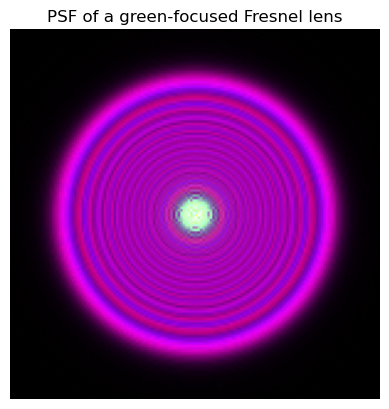

In [3]:
fresnel_phase_c = build_baseline_profile(rgb_collim_model)
psf = rgb_collim_model.get_psf(fresnel_phase_c)
psf_baseline = crop_center_region(normalize_psf(to_ndarray(psf, debatch=True), clip_percentile=0.01, bandwise=False), size=150)
imshow(psf_baseline, titles=["PSF of a green-focused Fresnel lens"], off_axis=True)

Then, let's load a sample image, and generate the blurred observation with the baseline DOE model.

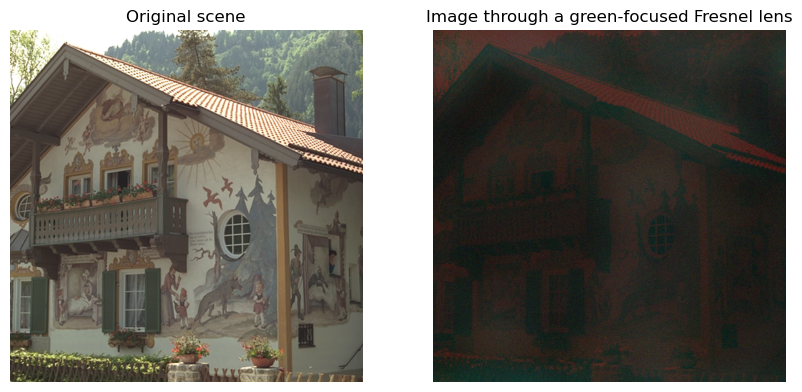

In [4]:
gt = load_sample_img(get_path('sample_data/optic_sample.png'))

sigma = 7.65 / 255
noise = torch.randn(*gt.shape, device=gt.device) * sigma
psf = rgb_collim_model.get_psf(fresnel_phase_c)
inp_baseline = img_psf_conv(gt, psf, circular=True) + noise
imshow(gt, inp_baseline, titles=['Original scene', 'Image through a green-focused Fresnel lens'], off_axis=True)

To reconstruct the clean image from the blurred observation, we could use plug-and-play proximal algorithm.

Here, we show an example of how to solve it with ADMM and a deep image prior in ∇-Prox.

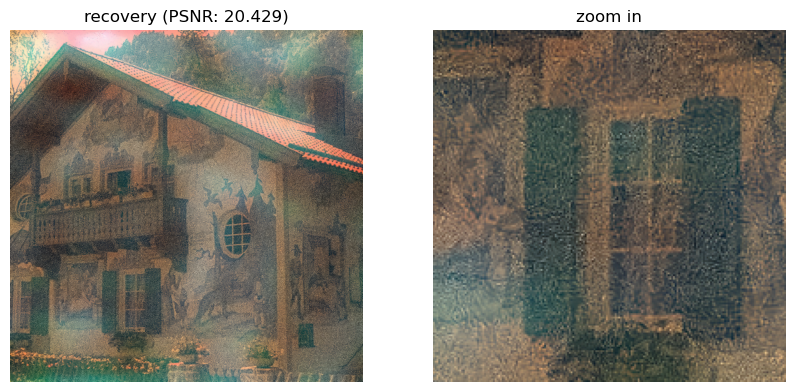

In [5]:
x = Variable()
y = Placeholder()
PSF = Placeholder()
data_term = sum_squares(conv_doe(x, PSF, circular=True), y)
reg_term = deep_prior(x, denoiser='ffdnet_color')
solver = compile(data_term + reg_term, method='admm')  # compile the optimization problem into an ADMM solver

inp = inp_baseline.float()
y.value, PSF.value = inp, psf
max_iter = 10
rhos, sigmas = log_descent(49, 7.65, max_iter, sigma=max(0.255 / 255, sigma))  # set inner loop parameters using a log descent policy
out_baseline = solver.solve(x0=inp, rhos=rhos, lams={reg_term: sigmas}, max_iter=max_iter)

imshow(out_baseline, out_baseline[:,:,460:660,140:340], titles=[f'recovery (PSNR: {psnr(out_baseline, gt):.3f})', 'zoom in'], off_axis=True)

From the results, we could see that naive DOE model (green-focused Fresnel lens) does not work well with existing post-processing techniques, such as the proximal algorithm we used here. To further increase cooperations between imaging model and processing algorithms. We could jointly optimize them. 

### Conventional Joint Optimization of DOE Model and Deep Deconvolution Network

In DeepOptics-UNet, Metzler et al propose to jointly optimize the DOE model and a post-deconvolution network. This results in a learned DOE model whose PSF can be visualized as follows. We could see the learned PSF is quite different from previous one, which focus more colors instead of solely a green channel. 

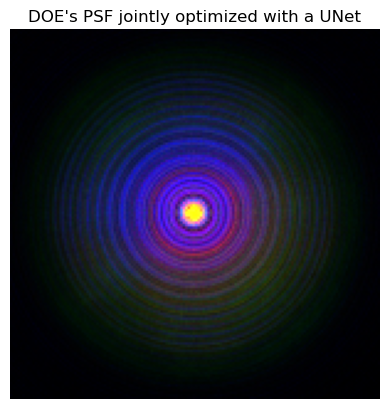

In [6]:
from dprox.utils.examples.optic.unet import U_Net
solver = U_Net(3,3).to(device)
rgb_collim_model = build_doe_model()

ckpt = torch.load(get_path('checkpoints/joint_unet.pth'))
rgb_collim_model.load_state_dict(ckpt['model'])
solver.load_state_dict(ckpt['solver'])

psf = rgb_collim_model.get_psf()
psf_unet = crop_center_region(normalize_psf(to_ndarray(psf, debatch=True), clip_percentile=0.01))
imshow(psf_unet, titles=["DOE's PSF jointly optimized with a UNet"], off_axis=True)

To see the performance of joint optimization, we could capture/generate an observation and see what results would the deconvolution network reconstruct.

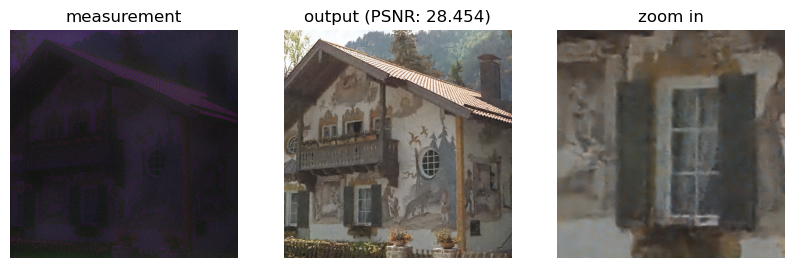

In [7]:
gt = gt.to(device).float()
psf = rgb_collim_model.get_psf()
inp = img_psf_conv(gt, psf, circular=True)
inp_unet = inp + torch.randn(*inp.shape, device=inp.device) * sigma

out_unet = solver(inp_unet)
imshow(inp_unet, out_unet, out_unet[:,:,460:660,140:340], titles=['measurement', f'output (PSNR: {psnr(out_unet, gt):.3f})', 'zoom in'], off_axis=True)

👻 Oops! We could see that the results is much better, which demonstrate the effectiveness of joint optimization. 

In fact, the above approach jointly optimize the DOE model and a black-box deconvolution network. However, how about the joint optimization of the DOE model with a formal optimization deconvolution algorithm, e.g. a proximal algorithm?

### DOE with Learned Profile in ∇-Prox

∇-Prox builds differentiable proximal solver that can be used to jointly optimize every input to the solver, e.g., the DOE model. 

For simplicity, we here provide the learned DOE model by ∇-Prox. The training code for it can be found in [computational_optics](). 

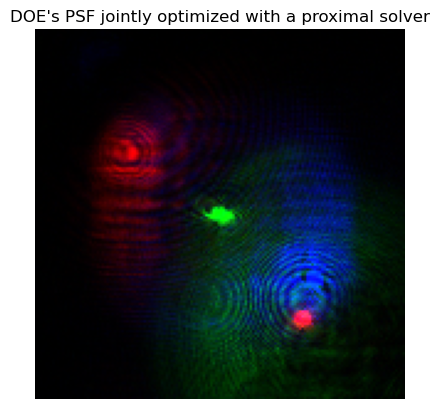

In [8]:
# load learned doe model
rgb_collim_model.rhos = nn.parameter.Parameter(torch.zeros((max_iter)))
rgb_collim_model.sigmas = nn.parameter.Parameter(torch.zeros((max_iter)))
rgb_collim_model.load_state_dict(torch.load(get_path('checkpoints/joint_proximal.pth'))['model'])

# visualize point spread function
psf = rgb_collim_model.get_psf()
psf_dprox = crop_center_region(normalize_psf(to_ndarray(psf, debatch=True), clip_percentile=0.01))
imshow(psf_dprox, titles=["DOE's PSF jointly optimized with a proximal solver"], off_axis=True)

Perhaps interestingly, the above visualization highlights that the optimized PSF resulting from the end-to-end optimization problem from above drastically differs from the one optimized with a UNet post-processor. 

The phase pattern we learn focuses the three wavelength bands as highly chromatic PSFs for each channel, that is, the red green and blue PSFs only focus for the specific channel while spreading out energy for other wavelengths over the entire sensor. 

By spatially separating the corresponding phase patterns, our co-designed network is able to find these chromatic PSFs. As such, ∇-Prox allowed us to find a novel point in the design space -- turning an out-of-focus deconvolution problem into a transverse chromatic alignment problem. 🙀

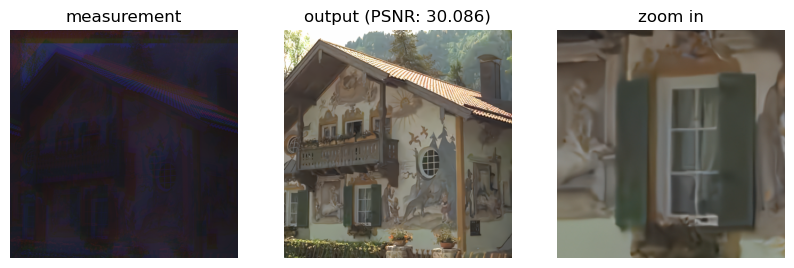

In [9]:
# generate input
gt = gt.to(device).float()
psf = rgb_collim_model.get_psf()
inp = img_psf_conv(gt, psf, circular=True)
inp_dprox = inp + torch.randn(*inp.shape, device=inp.device) * sigma

# build solver
x = Variable()
y = Placeholder()
PSF = Placeholder()
data_term = sum_squares(conv_doe(x, PSF, circular=True), y)
reg_term = deep_prior(x, denoiser='ffdnet_color')
solver = compile(data_term + reg_term, method='admm')

# solve the problem
y.value = inp_dprox
PSF.value = psf
with torch.no_grad():
    out_dprox = solver.solve(x0=inp_dprox,
                        rhos=rgb_collim_model.rhos,
                        lams={reg_term: rgb_collim_model.sigmas},
                        max_iter=max_iter)

imshow(inp, out_dprox, out_dprox[:,:,460:460+200,140:140+200], titles=['measurement', f'output (PSNR: {psnr(out_dprox, gt):.3f})', 'zoom in'], off_axis=True)

In a nutshell, the model-based proximal optimization solver compiled with ∇-Prox finds a better local minimum with a significantly improved end-to-end loss, which validates the effectiveness of the differentiable pipelines we compile.

**Wrap up the results**

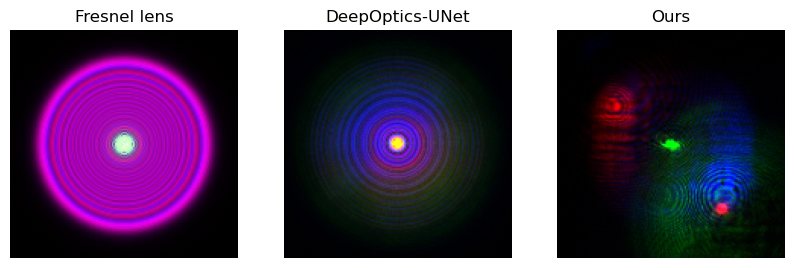

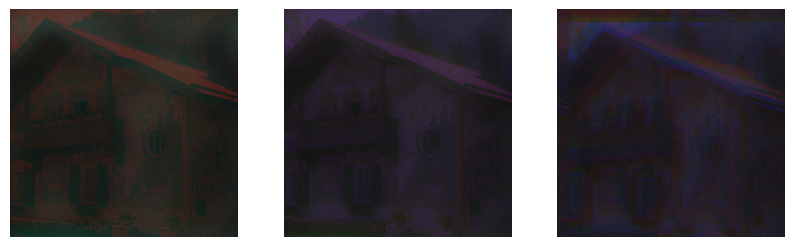

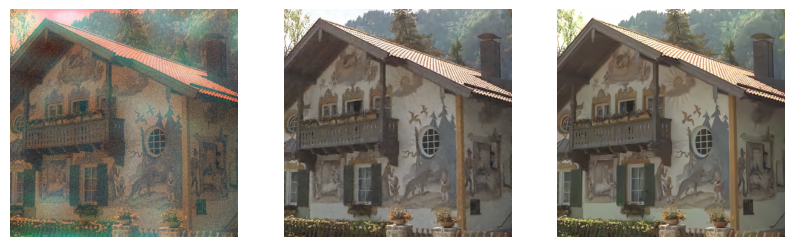

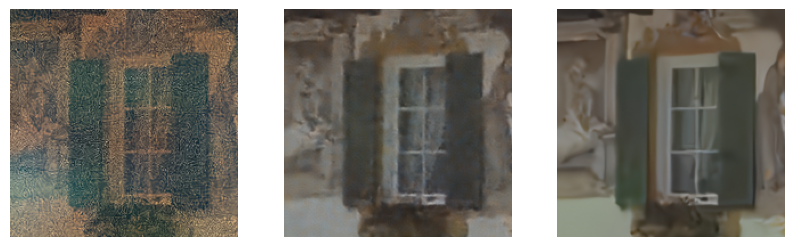

PSNR - Baseline: 20.429132587349102 DeepOptics-Unet: 28.453814331529394 Ours: 30.085912477403927


In [11]:
imshow(psf_baseline, psf_unet, psf_dprox, off_axis=True, titles=['Fresnel lens', 'DeepOptics-UNet', 'Ours'])
imshow(inp_baseline, inp_unet, inp_dprox, off_axis=True)
imshow(out_baseline, out_unet, out_dprox, off_axis=True)
imshow(out_baseline[:,:,460:460+200,140:140+200], out_unet[:,:,460:460+200,140:140+200], out_dprox[:,:,460:460+200,140:140+200], off_axis=True)
print('PSNR - Baseline: {} DeepOptics-Unet: {} Ours: {}'.format(psnr(gt, out_baseline), psnr(gt, out_unet), psnr(gt, out_dprox)))

## Reference

[Haim et al. 2018] Harel Haim, Shay Elmalem, Raja Giryes, Alex Bronstein, and Emanuel Marom. 2018. Depth Estimation From a Single Image Using Deep Learned Phase Coded Mask. IEEE Transactions on Computational Imaging 4 (2018), 298–310.
 
[Horstmeyer et al. 2017] Roarke Horstmeyer, Richard Y. Chen, Barbara Kappes, and Benjamin Judkewitz. 2017. Convolutional neural networks that teach microscopes how to image. ArXiv abs/1709.07223 (2017).

[Metzler et al. 2020] Christopher A Metzler, Hayato Ikoma, Yifan Peng, and Gordon Wetzstein. 2020. Deep optics for single-shot high-dynamic-range imaging. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 1375–1385.